In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Path to the main directory
folder_path = '/content/gdrive/My Drive/Colab Notebooks/InnSure/pdl_query/'
breach1_path = folder_path + 'breached_executives.csv'
control1_path = folder_path + 'control_p1.csv'
control2_path = folder_path + 'control_p2.csv'

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import time
from datetime import datetime
import pickle
import os
from ast import literal_eval

In [ ]:
# load 1106 profiles
breach1 = pd.read_csv(breach1_path)
control1 = pd.read_csv(control1_path)
control2 = pd.read_csv(control2_path)

In [ ]:
breach1['breach']=1
control1['breach']=0
control2['breach']=0

In [ ]:
#df = pd.concat([control1, breach1], ignore_index=True, sort=True)  #keep all columns in both dfs
profiles_inner = pd.concat([breach1,control1,control2],join='inner', ignore_index=True)
profiles_outer =  pd.concat([breach1,control1,control2],join='outer', ignore_index=True)


In [ ]:
profiles_full =  pd.concat([breach1,control2],join='inner', ignore_index=True)

In [ ]:
profiles_full.info()
profiles_full.to_csv('mergedProfiles_BreachCtrl2.csv')  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Columns: 307 entries, Unnamed: 0 to breach
dtypes: float64(6), int64(289), object(12)
memory usage: 1.6+ MB


In [ ]:
profiles_outer.info()
profiles_outer.to_csv('mergedProfiles_allCols.csv')  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Columns: 307 entries, Unnamed: 0 to breach
dtypes: float64(18), int64(277), object(12)
memory usage: 1.9+ MB


In [ ]:
profiles_inner.info()
profiles_inner.to_csv('mergedProfiles_commonCols.csv')  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Columns: 294 entries, Unnamed: 0 to breach
dtypes: float64(5), int64(277), object(12)
memory usage: 1.8+ MB


# **Upload merged file for analysis**

In [ ]:
profiles_inner.columns.tolist()

In [ ]:
profiles = profiles_inner.copy()

profiles = profiles.drop(['birth_year','est_age_at_breach'], 1)

#NUMBER PF 
profiles['num_social_media'] = profiles['linkedin_url']+ profiles['facebook_url'] + profiles['twitter_url']
#profiles['num_infosec_certs'] = profiles['cissp']+profiles['ccna']+profiles['ccnp']+profiles['cbcp']+profiles['cciso']+profiles['ccsp']+profiles['cism']+profiles['cisa']+profiles['cisp']+profiles['crisc']+profiles['chcio']

profiles= profiles[['breach','gender','breach_company_size','highest_level','num_social_media','proxy_yrs_since_edu', 'yrs_in_til_breach',
                       'true_yrs_of_exp', 'mba','jd','md','technical','business','other','educational','nonprofit','private','public']]
# Remove rows with all 0s
profiles = profiles.loc[:, (profiles != 0).any(axis=0)]

# list of categorical features
cat = ['breach','gender','breach_company_size','highest_level','mba','jd','md']

# in each column fill NA with 'missing'
# change values in cat to category type:

1# impute missing values of proxy_yrs_since_edu with median
profiles['proxy_yrs_since_edu'] = profiles['proxy_yrs_since_edu'].fillna(profiles['proxy_yrs_since_edu'].median())

for i in cat:
  profiles[i] = profiles[i].fillna('missing')
  profiles[i] = profiles[i].astype('category')




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
categorical_mask = (profiles.dtypes == 'category')
categorical_columns = profiles.columns[categorical_mask].tolist()
print(profiles[categorical_columns].head())

  breach   gender breach_company_size highest_level mba jd md
0      1     male              10001+    doctorates   0  0  1
1      1     male              10001+       masters   1  0  0
2      1  missing              10001+    doctorates   0  0  1
3      1     male              10001+       missing   0  0  0
4      1     male           1001-5000     bachelors   0  0  0


# **Visualizations**

In [ ]:
plot_review = profiles.breach.value_counts().reset_index()
plot_review

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="index",y="breach",data=plot_review)

ax.set_title('Breach Status Count', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Breach status', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

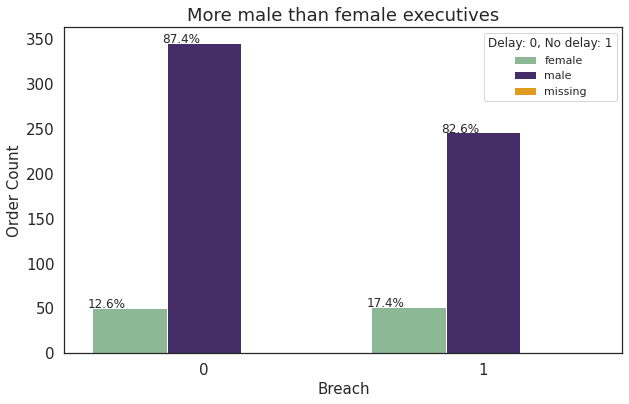

In [ ]:
gender = profiles[profiles['gender'] != 'missing']


plt.figure(figsize = (10,6))
sns.set_style("white")
ax = sns.countplot(x='breach', hue='gender', data= gender, palette=['#86bf91','#432371','orange'])
plt.xlabel('Breach', fontsize=15)
plt.ylabel('Order Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('More male than female executives', fontsize=18)

plt.legend(title="Delay: 0, No delay: 1",title_fontsize=12,fancybox=True)
with_hue(ax, gender.breach, 2, 3)



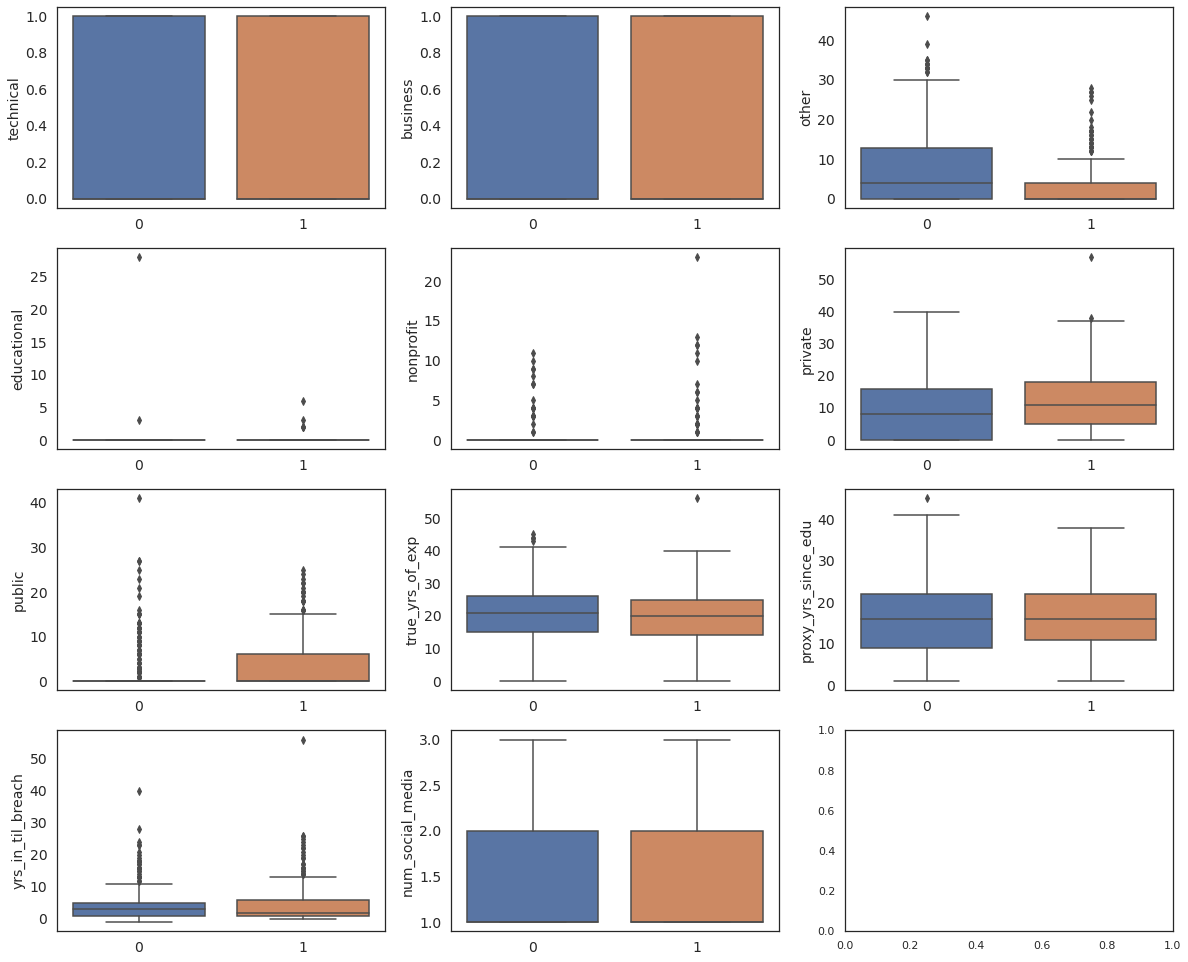

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(20,17))
vars = ['technical','business','other','educational','nonprofit','private','public','true_yrs_of_exp',
        'proxy_yrs_since_edu','yrs_in_til_breach','num_social_media']
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
for i in range(len(vars)):
  sns.boxplot(x="breach",y=profiles[vars[i]],data=profiles,ax=axes[i])
  axes[i].set_ylabel(vars[i], fontsize=14)
  axes[i].set_xlabel('')
  axes[i].xaxis.set_tick_params(labelsize=14)
  axes[i].yaxis.set_tick_params(labelsize=14)


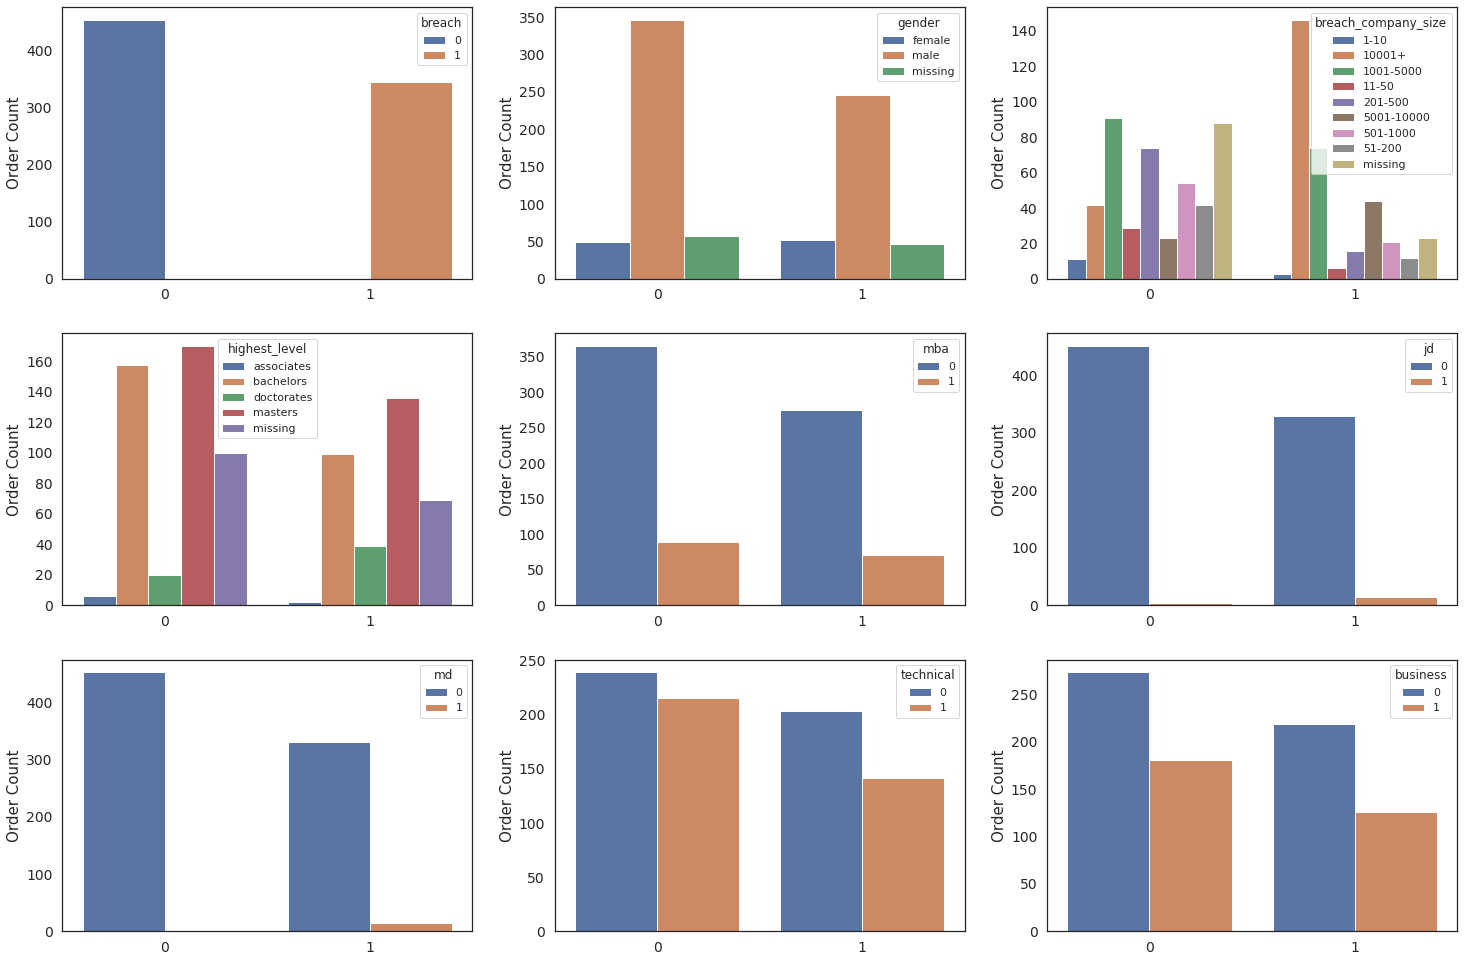

In [ ]:
#categorical features:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(25,17))
vars = ['breach','gender','breach_company_size','highest_level','mba','jd','md','technical','business']
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

for i in range(len(vars)):
  #sns.set(rc={'figure.figsize':(10,6)})
  sns.set_style("white")
  sns.countplot(x='breach', hue=vars[i], data= profiles,ax=axes[i])#, palette=['#86bf91','#432371','orange'])
  axes[i].set_xlabel('', fontsize=15)
  axes[i].set_ylabel('Order Count', fontsize=15)
  axes[i].xaxis.set_tick_params(labelsize=14)
  axes[i].yaxis.set_tick_params(labelsize=14)


In [ ]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

In [ ]:
len(profiles.breach_company_size.unique())

9

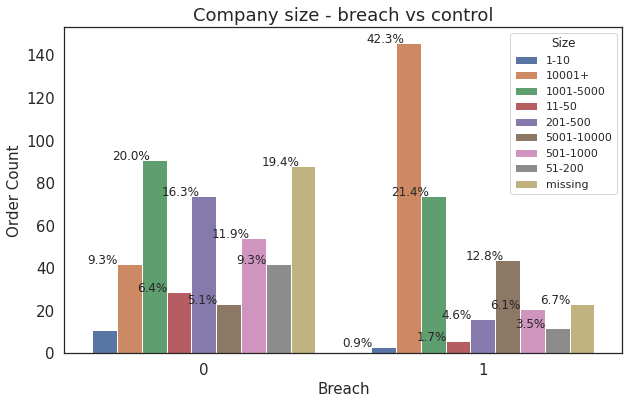

In [ ]:
#sns.set(rc={'figure.figsize':(10,6)})
#sns.set_style("white")
plt.figure(figsize = (10,6))
ax = sns.countplot(x='breach', hue='breach_company_size', data= profiles)#, palette=['#86bf91','#432371','orange'])
plt.xlabel('Breach', fontsize=15)
plt.ylabel('Order Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Company size - breach vs control', fontsize=18)
plt.legend(title="Size",title_fontsize=12,fancybox=True)

with_hue(ax, profiles.breach, 2, 9)

In [ ]:
"""
# size of company
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style("white")
sns.countplot(x='breach', hue='mba', data= profiles)#, palette=['#86bf91','#432371','orange'])
plt.xlabel('Breach', fontsize=15)
plt.ylabel('Order Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Company size - breach vs control', fontsize=18)
plt.legend(title="Size",title_fontsize=12,fancybox=True)
"""

'\n# size of company\nsns.set(rc={\'figure.figsize\':(10,6)})\nsns.set_style("white")\nsns.countplot(x=\'breach\', hue=\'mba\', data= profiles)#, palette=[\'#86bf91\',\'#432371\',\'orange\'])\nplt.xlabel(\'Breach\', fontsize=15)\nplt.ylabel(\'Order Count\', fontsize=15)\nplt.xticks(fontsize=15)\nplt.yticks(fontsize=15)\nplt.title(\'Company size - breach vs control\', fontsize=18)\nplt.legend(title="Size",title_fontsize=12,fancybox=True)\n'

# **Explore SKILLS and INDUSTRY variables**

In [ ]:
a = [col for col in profiles_inner.columns if col.endswith('_skill')]
a.append('breach')
skills = profiles_inner[a]
print(len(skills.columns.tolist()))


b = [col for col in profiles_inner.columns if col.endswith('_industry')]
b.append('breach')
industries = profiles_inner[b]
print(len(industries.columns.tolist()))


101
152


In [ ]:
skills.head(4)
skills1 = skills.loc[:, (skills != 0).any(axis=0)]
skills1 = skills1.fillna(0)
print(len(skills1.columns.tolist()))


industries.head(4)
industries1 = industries.loc[:, (industries != 0).any(axis=0)]
industries1 = industries1.fillna(0)
print(len(industries1.columns.tolist()))

60
124


In [ ]:
profiles_inner['leisure, travel & tourism_industry']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
794   NaN
795   NaN
796   NaN
797   NaN
798   NaN
Name: leisure, travel & tourism_industry, Length: 799, dtype: float64

In [ ]:
#number of non-zero values in each column
#number of profiles with this industry
count_industries = industries1.astype(bool).sum(axis=0)
count_industries.sort_values(ascending= False).head(20)

current_industry                                793
breach_industry                                 771
other_industry                                  396
breach                                          345
hospital & health care_industry                 228
information technology and services_industry    213
financial services_industry                     125
higher education_industry                        93
computer software_industry                       92
government administration_industry               85
insurance_industry                               74
telecommunications_industry                      59
banking_industry                                 50
internet_industry                                49
retail_industry                                  37
management consulting_industry                   35
computer & network security_industry             31
education management_industry                    28
accounting_industry                              28
non-profit o

In [ ]:
#number of profiles with this skill
count_skills = skills1.astype(bool).sum(axis=0)
count_skills.sort_values(ascending= False)

management_skill                           410
project management_skill                   370
breach                                     345
program management_skill                   317
vendor management_skill                    312
process improvement_skill                  300
disaster recovery_skill                    290
business process improvement_skill         233
cloud computing_skill                      228
enterprise architecture_skill              212
business intelligence_skill                211
enterprise software_skill                  202
data center_skill                          191
change management_skill                    184
network security_skill                     173
healthcare information technology_skill    153
networking_skill                           153
team building_skill                        150
team leadership_skill                      148
risk management_skill                      141
hipaa_skill                                137
cross functio

# **Machine learning**

In [ ]:
# Create LabelEncoder object: le
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
profiles[categorical_columns] = profiles[categorical_columns].apply(lambda x: le.fit_transform(x))

In [ ]:
print(profiles[categorical_columns].head())

   breach  gender  breach_company_size  highest_level  mba  jd  md
0       1       1                    1              2    0   0   1
1       1       1                    1              3    1   0   0
2       1       2                    1              2    0   0   1
3       1       1                    1              4    0   0   0
4       1       1                    2              1    0   0   0


In [ ]:
profiles.breach.value_counts()

0    454
1    345
Name: breach, dtype: int64

#### **Now One-hot encode gender, breach_company_size, highest_level**

In [ ]:
profiles = pd.get_dummies(data=profiles, columns=['gender', 'breach_company_size','highest_level'])

In [ ]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   breach                 799 non-null    int64  
 1   num_social_media       799 non-null    int64  
 2   proxy_yrs_since_edu    799 non-null    float64
 3   yrs_in_til_breach      799 non-null    int64  
 4   true_yrs_of_exp        799 non-null    int64  
 5   mba                    799 non-null    int64  
 6   jd                     799 non-null    int64  
 7   md                     799 non-null    int64  
 8   technical              799 non-null    int64  
 9   business               799 non-null    int64  
 10  other                  799 non-null    int64  
 11  educational            799 non-null    int64  
 12  nonprofit              799 non-null    int64  
 13  private                799 non-null    int64  
 14  public                 799 non-null    int64  
 15  gender

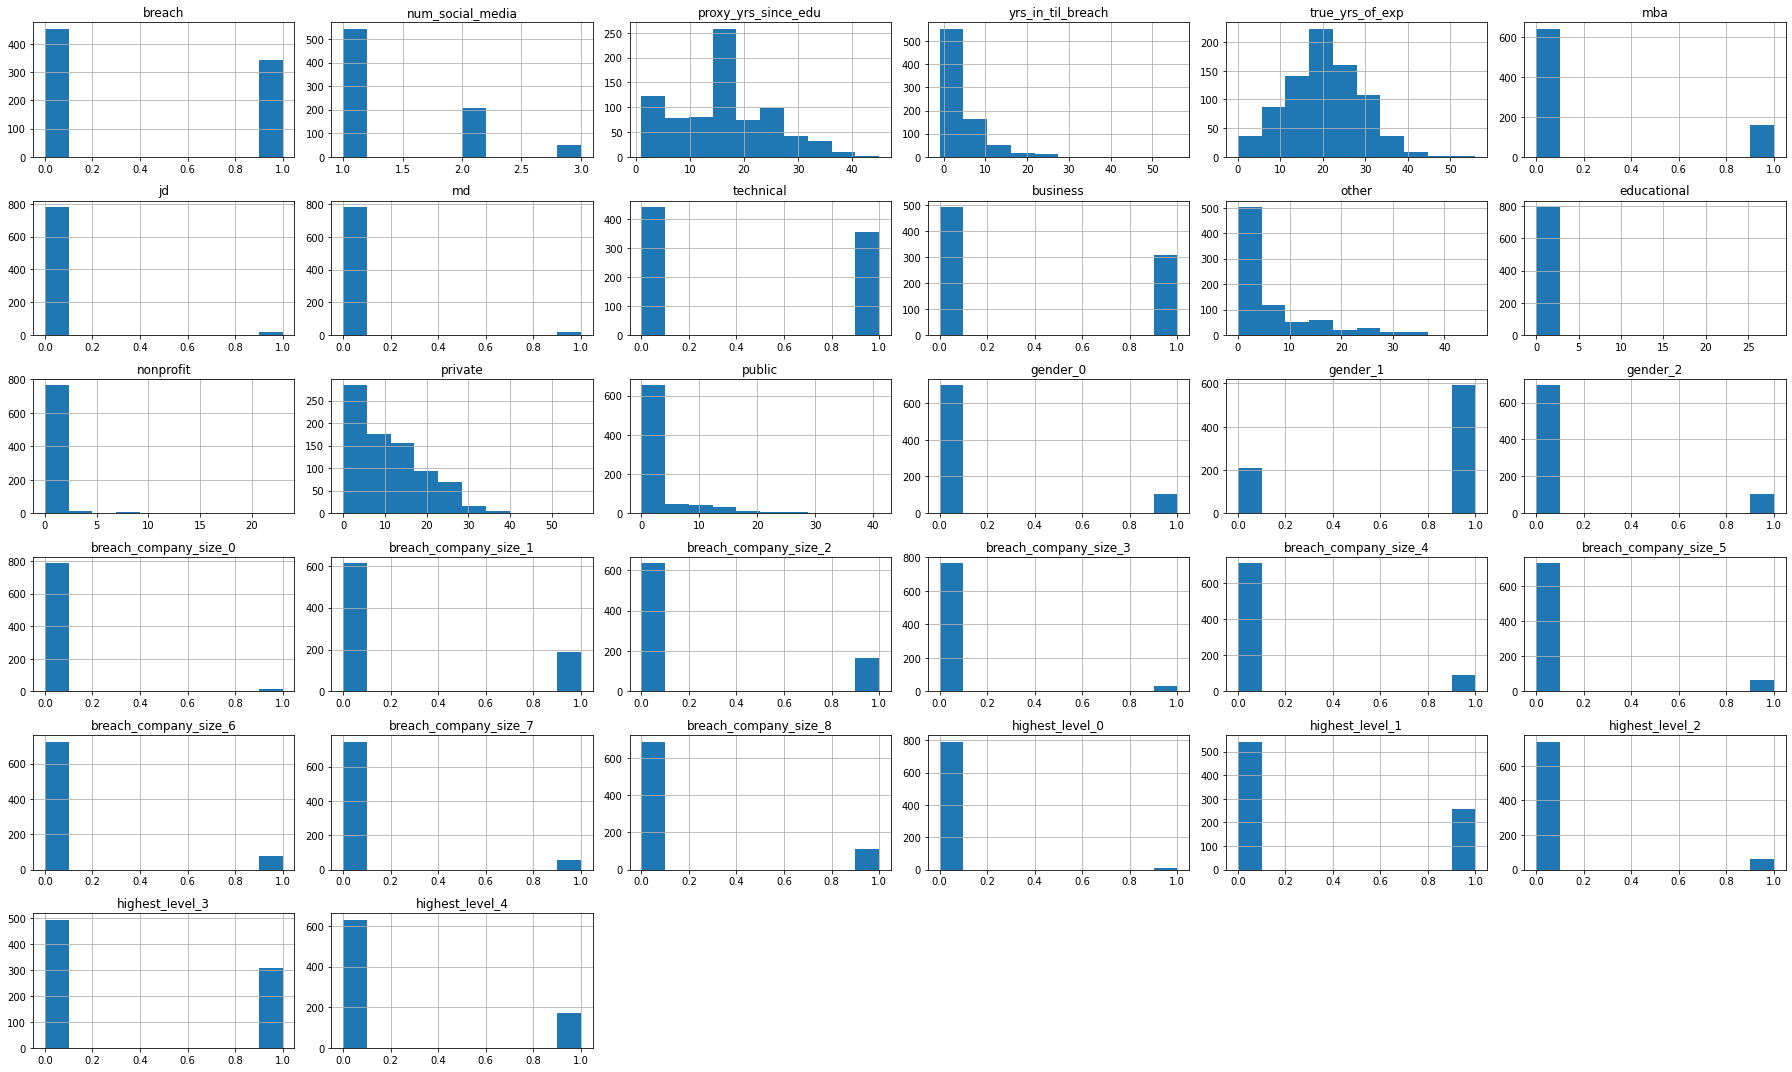

In [ ]:
# Checking the distributions of predictor features
import matplotlib.pyplot as plt
profiles[profiles.describe().columns].hist(figsize=(25,15));
plt.tight_layout()
plt.show()


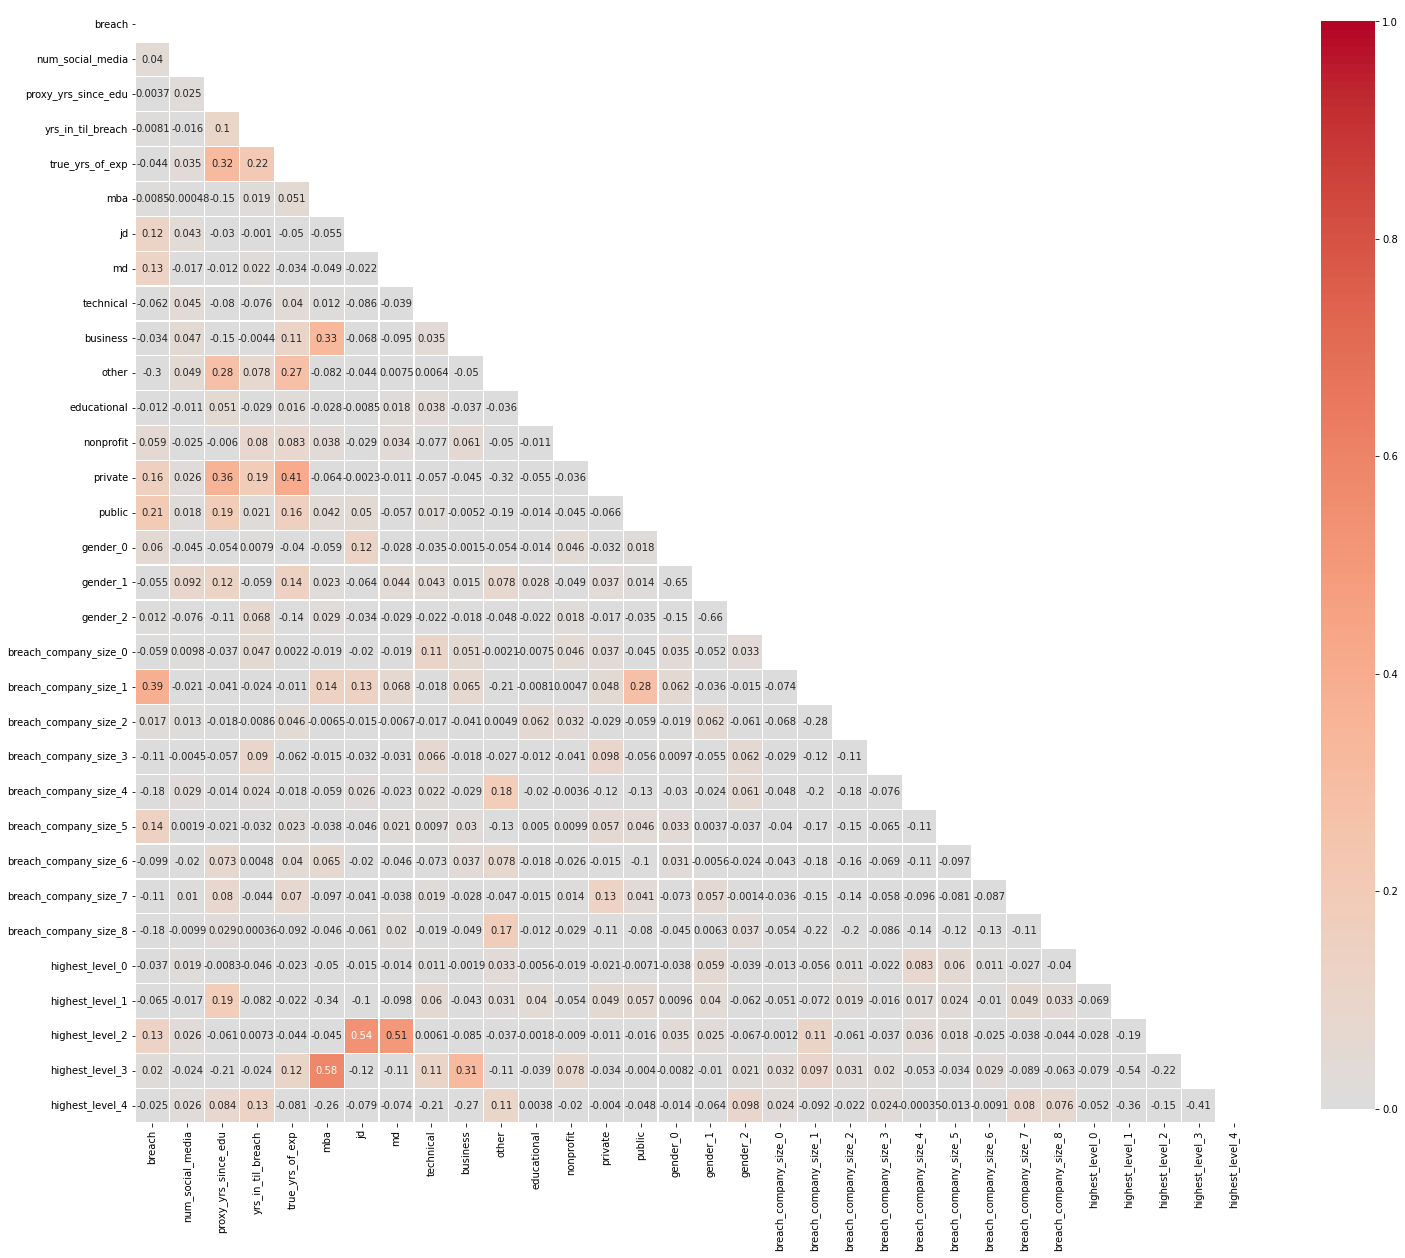

In [ ]:
import seaborn as sns
#Create the collinearity matrix

corr = profiles.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True) #Color
mask = np.triu(np.ones_like(corr, dtype=bool)) #Masking the diagonoal and above
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(corr, center=0, cmap="coolwarm", square=True,
linewidth=0.3, cbar_kws={"shrink": .8}, annot=True, mask=mask, vmin=0, vmax=1)
#ax.set_title("Multi-Collinearity of the Olist dataset", fontsize=12)

sns.set(font_scale=1.5) 

## **Machine Learning**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

## **Standardize Data using StandardScaler()**

Finally, the dependent (y) and independent (X) features will be separated into separate datasets. Because the features are on different scales, independent features will be transformed and normalised using StandardScaler.

df_model is my clean data set to use for modeling. I will split it into train and test set, fit the scaler on your training data only, then standardise both training and test sets with that scaler. By fitting the scaler on the full dataset prior to splitting, information about the test set is used to transform the training set, which in turn is passed downstream.


In [ ]:
X_unscaled = profiles.drop('breach', axis=1)
y = profiles.breach

In [ ]:
y.value_counts()

0    454
1    345
Name: breach, dtype: int64

In [ ]:
SEED = 1911
jobs = -1
X_train, X_test, y_train, y_test = train_test_split(X_unscaled, y, test_size=0.20, stratify=y, random_state=SEED)

In [ ]:
# Transforming the data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)  

  
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)  


In [ ]:
X_test_scaled

,num_social_media,proxy_yrs_since_edu,yrs_in_til_breach,true_yrs_of_exp,mba,jd,md,technical,business,other,...,breach_company_size_4,breach_company_size_5,breach_company_size_6,breach_company_size_7,breach_company_size_8,highest_level_0,highest_level_1,highest_level_2,highest_level_3,highest_level_4
232,1.026701,1.465914,0.532455,-0.266763,-0.502933,-0.160257,-0.155043,-0.920229,1.25978,1.472693,...,-0.345093,3.291403,-0.333623,-0.284988,-0.381000,-0.105242,1.43437,-0.303822,-0.796411,-0.483312
140,-0.642668,0.017781,-0.430303,-1.079590,-0.502933,-0.160257,-0.155043,1.086686,-0.79379,-0.060171,...,-0.345093,-0.303822,-0.333623,-0.284988,-0.381000,-0.105242,-0.69717,-0.303822,1.255632,-0.483312
374,1.026701,0.017781,-0.045200,0.894419,-0.502933,-0.160257,-0.155043,-0.920229,-0.79379,3.005557,...,-0.345093,-0.303822,-0.333623,-0.284988,2.624669,-0.105242,-0.69717,-0.303822,-0.796411,2.069056
443,2.696070,-1.318956,-0.622855,1.358891,-0.502933,-0.160257,-0.155043,1.086686,1.25978,0.578522,...,-0.345093,-0.303822,-0.333623,-0.284988,2.624669,-0.105242,-0.69717,-0.303822,-0.796411,2.069056
769,-0.642668,-0.427798,0.147352,0.313828,-0.502933,-0.160257,-0.155043,-0.920229,-0.79379,-0.698864,...,2.897768,-0.303822,-0.333623,-0.284988,-0.381000,-0.105242,-0.69717,-0.303822,1.255632,-0.483312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,-0.642668,-1.541746,-0.237752,0.313828,-0.502933,-0.160257,-0.155043,-0.920229,1.25978,-0.187910,...,-0.345093,-0.303822,2.997395,-0.284988,-0.381000,-0.105242,1.43437,-0.303822,-0.796411,-0.483312
376,1.026701,0.017781,0.339904,1.475010,-0.502933,-0.160257,-0.155043,1.086686,-0.79379,3.644250,...,2.897768,-0.303822,-0.333623,-0.284988,-0.381000,-0.105242,-0.69717,-0.303822,-0.796411,2.069056
125,-0.642668,0.017781,-0.622855,0.197710,-0.502933,-0.160257,-0.155043,-0.920229,-0.79379,-0.698864,...,-0.345093,-0.303822,-0.333623,-0.284988,-0.381000,-0.105242,-0.69717,-0.303822,-0.796411,2.069056
636,1.026701,1.243124,-0.622855,-0.731236,-0.502933,-0.160257,-0.155043,1.086686,-0.79379,0.450784,...,-0.345093,-0.303822,2.997395,-0.284988,-0.381000,-0.105242,-0.69717,-0.303822,-0.796411,2.069056


# **Modeling:**

In this section, machine learning models for classification will be applied to the data, in order to create a model to classify projects into positives and negatives.


We will create a logistic regression model to classify projects into successes and failures. We will try it with original data and again with log-transformed data, to see which one is better

## **Model 1: logistic regression**

In [ ]:
# Fitting a logistic regression model with default parameters
from sklearn.linear_model import LogisticRegression, SGDClassifier
logreg = LogisticRegression(random_state=SEED, n_jobs=jobs)

In [ ]:
logreg.fit(X_train_scaled,y_train)
# Making predictions
lr_y_hat_train = logreg.predict(X_train_scaled)
lr_y_hat_test = logreg.predict(X_test_scaled)

In [ ]:
# Logistic regression scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_precision_recall_curve
from sklearn.metrics import make_scorer, precision_recall_curve, classification_report
print("Logistic regression score for training set:", round(logreg.score(X_train_scaled, y_train),5))
print("Logistic regression score for test set:", round(logreg.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, lr_y_hat_test))

Logistic regression score for training set: 0.76839
Logistic regression score for test set: 0.725

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        91
           1       0.69      0.67      0.68        69

    accuracy                           0.73       160
   macro avg       0.72      0.72      0.72       160
weighted avg       0.72      0.72      0.72       160



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, lr_y_hat_test)
cm

array([[70, 21],
       [23, 46]])

In [ ]:
import itertools
def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    plt.grid(b=None)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

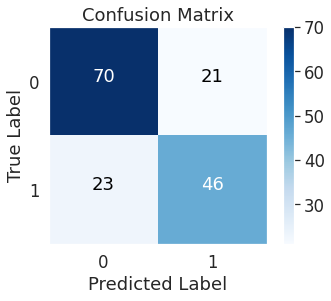

In [ ]:
# Confusion matrix
plot_cf(y_test, lr_y_hat_test)

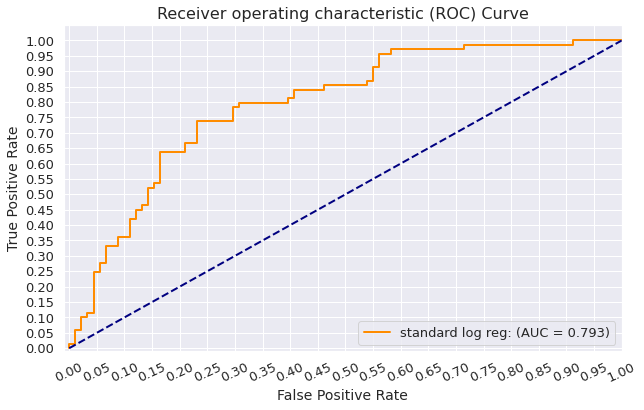

In [ ]:
from sklearn import metrics
lr_y_hat_proba = logreg.predict_proba(X_test_scaled)[::,1]
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test,  lr_y_hat_proba)
lr_auc = metrics.roc_auc_score(y_test, lr_y_hat_proba)

#create ROC curve

from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(10,6))
lw = 2
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.plot(lr_fpr, lr_tpr, label='standard log reg: (AUC = %0.3f)' % lr_auc, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.yticks([i/20.0 for i in range(21)], fontsize=13)
plt.xticks([i/20.0 for i in range(21)], fontsize=13, rotation = 25)
plt.title('Receiver operating characteristic (ROC) Curve',fontsize=16)
plt.legend(loc=4, fontsize=13)

#from matplotlib.ticker import FormatStrFormatter
#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

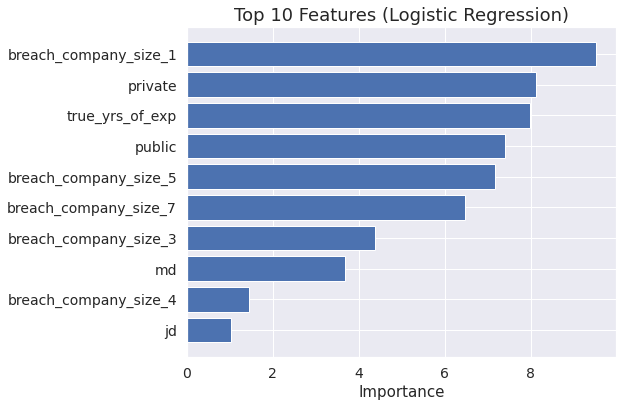

In [ ]:
lr_feature_importance = abs(logreg.coef_[0])
lr_feature_importance = 100.0 * (lr_feature_importance / lr_feature_importance.max())
sorted_idx = np.argsort(lr_feature_importance)
sorted_idx_10 = sorted_idx[:10]
#pos = np.arange(sorted_idx.shape[0]) + .5
pos_10 = np.arange(sorted_idx_10.shape[0]) + .05
lr_feature_importance_10=lr_feature_importance[sorted_idx][:10]


featfig = plt.figure(figsize=(9,6))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos_10, lr_feature_importance_10, align='center')
featax.set_yticks(pos_10)
featax.set_yticklabels(np.array(X_unscaled.columns)[sorted_idx][-10:], fontsize=12)
featax.tick_params(axis='both', which='major', labelsize=14)
featax.set_xlabel('Relative Feature Importance',fontsize=15)
featax.set_xlabel('Importance',fontsize=15)
featax.set_title('Top 10 Features (Logistic Regression)',fontsize=18)

plt.tight_layout()   
plt.show()


## **Model 2: Random Forest Classifier**

Random Forest score for training set: 1.0
Random Forest score for test set: 0.71875

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        91
           1       0.69      0.64      0.66        69

    accuracy                           0.72       160
   macro avg       0.71      0.71      0.71       160
weighted avg       0.72      0.72      0.72       160



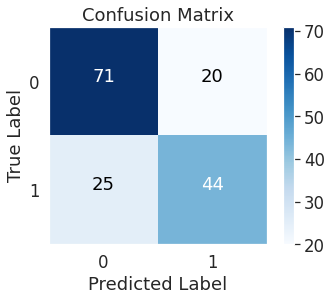

In [ ]:
# Random Forest scores
rf = RandomForestClassifier(random_state=SEED).fit(X_train_scaled, y_train)
rf_y_hat_train = rf.predict(X_train_scaled)
rf_y_hat_test = rf.predict(X_test_scaled)
print("Random Forest score for training set:", round(rf.score(X_train_scaled, y_train),5))
print("Random Forest score for test set:", round(rf.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, rf_y_hat_test))
plot_cf(y_test, rf_y_hat_test)

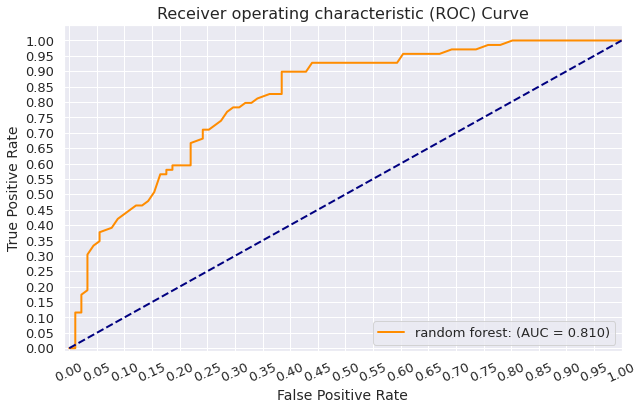

In [ ]:
from sklearn import metrics
rf_y_hat_proba = rf.predict_proba(X_test_scaled)[::,1]
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test,  rf_y_hat_proba)
rf_auc = metrics.roc_auc_score(y_test, rf_y_hat_proba)

#create ROC curve

from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(10,6))
lw = 2
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.plot(rf_fpr, rf_tpr, label = 'random forest: (AUC = %0.3f)' % rf_auc, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.yticks([i/20.0 for i in range(21)], fontsize=13)
plt.xticks([i/20.0 for i in range(21)], fontsize=13, rotation = 25)
plt.title('Receiver operating characteristic (ROC) Curve',fontsize=16)
plt.legend(loc=4, fontsize=13)

#from matplotlib.ticker import FormatStrFormatter
#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

In [ ]:
input_features = np.array(X_train_scaled.columns)
features_imp_rf = pd.DataFrame({'feature_name': input_features, 'feature_importance': rf.feature_importances_})
features_imp_rf = features_imp_rf.sort_values(by='feature_importance', ascending=False)

#### Plotting **Feature Importance** obtained from Random Forest Classifier.

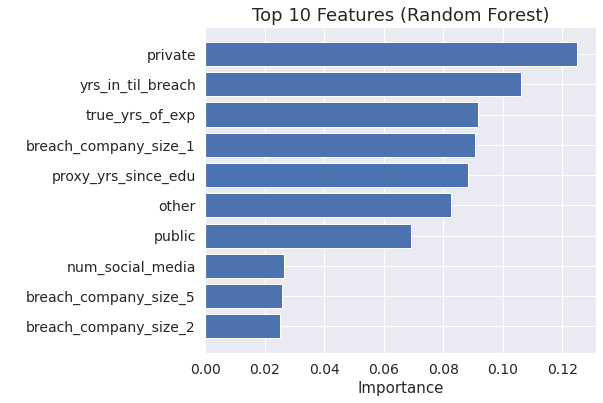

In [ ]:
features_imp_rf_10 = features_imp_rf.head(10)

plt.figure(figsize=(7,6))
plt.barh(y=features_imp_rf_10['feature_name'], width=features_imp_rf_10['feature_importance'])
plt.xlabel("Importance",fontsize=15)
plt.ylabel(" ",fontsize=15)
plt.title("Top 10 Features (Random Forest)",fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.gca().invert_yaxis()

#featax.set_yticklabels(np.array(X_unscaled.columns)[sorted_idx][-20:], fontsize=12)

## **Model 3: SVM (with Kernel)**


SVM score for training set: 0.74491
SVM score for test set: 0.66875

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        91
           1       0.65      0.51      0.57        69

    accuracy                           0.67       160
   macro avg       0.66      0.65      0.65       160
weighted avg       0.67      0.67      0.66       160

Accuracy: 0.66875
Precision: 0.6481481481481481
Recall: 0.5072463768115942


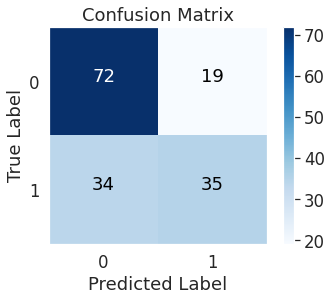

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svm_clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svm_clf.fit(X_train_scaled, y_train)

#Predict the response for test dataset
svm_y_hat_train = svm_clf.predict(X_train_scaled)
svm_y_hat_test = svm_clf.predict(X_test_scaled)
print("SVM score for training set:", round(svm_clf.score(X_train_scaled, y_train),5))
print("SVM score for test set:", round(svm_clf.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, svm_y_hat_test))
plot_cf(y_test, svm_y_hat_test)

print("Accuracy:",metrics.accuracy_score(y_test, svm_y_hat_test))
print("Precision:",metrics.precision_score(y_test, svm_y_hat_test))
print("Recall:",metrics.recall_score(y_test, svm_y_hat_test))

